In [2]:
#!pip install --upgrade torchvision -q
!pip install segmentation_models_pytorch lightly prefetch_generator torchinfo -q
!pip install -U albumentations wandb -q 

In [3]:
from pathlib import Path
import torch
import time
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
# from torch.cuda.amp import GradScaler, autocast
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights
from transformers import ViTModel, ViTConfig
from segmentation_models_pytorch import Unet, encoders
from torchvision.io import read_image, ImageReadMode
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy import ndimage
from scipy.signal import medfilt2d, wiener
import random
import cv2
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import barlow_twins_loss
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
from prefetch_generator import BackgroundGenerator
from rich import print
from torchmetrics import MetricCollection
from torchmetrics.image import PeakSignalNoiseRatio, SpatialCorrelationCoefficient, StructuralSimilarityIndexMeasure, RootMeanSquaredErrorUsingSlidingWindow

In [4]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [6]:
DATA_ROOT = Path("/kaggle/input/cresis-radar-depth-sounder/")
season_name = DATA_ROOT / "2023_Antarctica_BaslerMKB"
img_list = glob.glob("**/*.jpg",recursive=True, root_dir=season_name)
img_list = [season_name / f for f in img_list]

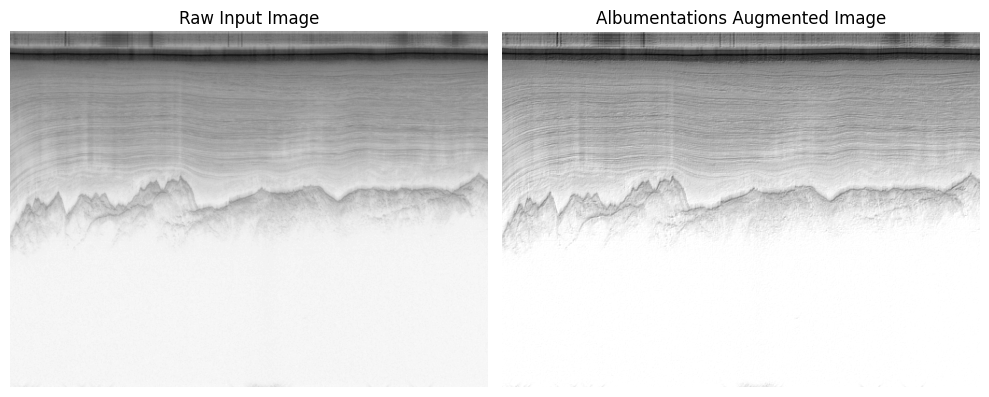

In [22]:
from PIL import Image
import random 
def load_image_torchvision(filepath):
        return read_image(filepath, mode=ImageReadMode.GRAY)

def need_permute(image):
    if len(image.shape) == 3:
            image = image.permute(1, 2, 0)
    return image
    
def plot_og_and_new(og_image, new_image, titles: (str, str)):
    og_image, new_image = need_permute(og_image), need_permute(new_image)
    fig, ax = plt.subplots(1, 2, figsize=(10, 8))
    ax[0].imshow(og_image, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title(titles[0])
    
    ax[1].imshow(new_image, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(titles[1])
    
    plt.tight_layout()
    plt.show()
    
def show_image(image_path, enable_augmented=False, transforms=None):
    if not enable_augmented:
        image = load_image_torchvision(samp_path)
        image = need_permute(image)
        fig, ax = plt.subplots()
        ax.imshow(image_tensor, cmap="gray")
        plt.axis('off')
        plt.show()
        
    image = cv2.imread(image_path)
    aug_image = transforms(image=image)["image"]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plot_og_and_new(torch.from_numpy(image), aug_image, ("Raw Input Image", "Albumentations Augmented Image"))
    
def create_augmentation_pipe():
    return A.Compose([
    # A.Sharpen(),
    A.RandomBrightnessContrast(
        brightness_limit=0.05,contrast_limit=0.05
    ),
    A.GaussianBlur((5, 5), p=1),
    A.Emboss(alpha=(0.5, 0.9), strength=(0.4, 0.8)),
    A.RandomSnow(
        brightness_coeff=0.9,
        snow_point_range=(0.1, 0.3),
    ),
    # A.CLAHE(),
    A.ToGray(num_output_channels=1, always_apply=True),
    A.Normalize(),
    A.LongestMaxSize(512, interpolation=cv2.INTER_NEAREST),
    A.ToFloat(),
    ToTensorV2(),
])    
    
# Example usage
transforms = create_augmentation_pipe()
samp_path = random.choice(img_list)
show_image(samp_path, enable_augmented=True, transforms=transforms)

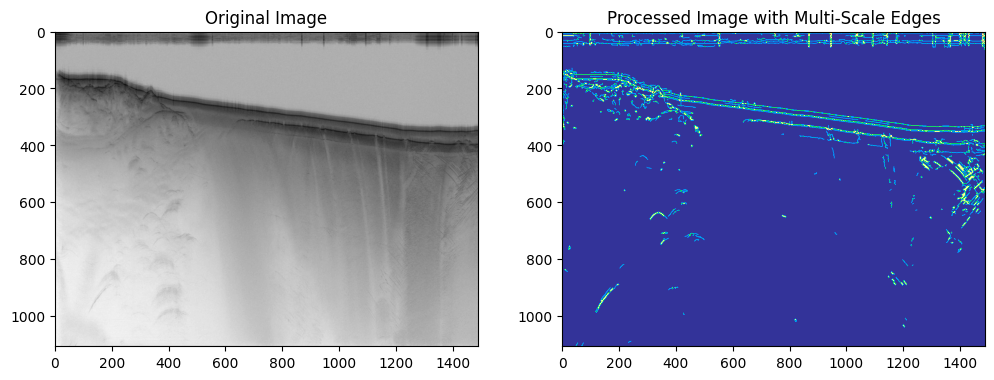

True

In [8]:
# Load the image
image_path = random.choice(img_list)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

transforms = A.Compose([
    # A.Emboss(p=1),
    A.RandomBrightnessContrast(0.05, 0.05, p=1),
    A.Posterize(8, p=1),
    A.GaussianBlur((5, 5), p=1)
])
# Step 1: Apply Gaussian blur
# blurred = cv2.GaussianBlur(image, (5, 5), 0)
blurred = transforms(image=image)["image"]


# Step 2: Apply multi-scale edge detection
edges = cv2.Canny(blurred, 25, 50)
edges2 = cv2.Canny(blurred, 50, 75)
edges3 = cv2.Canny(blurred, 75, 100)
edges4 = cv2.Canny(blurred, 125, 150)
# edges_multi_scale = cv2.Canny(blurred, 100, 150)
combined_edges1 = cv2.addWeighted(edges, 1, edges2, 1, 0)
combined_edges2 = cv2.addWeighted(edges3, 1, edges4, 1, 0)
combined_edges = cv2.addWeighted(combined_edges1, 0.5, combined_edges2, 0.5, 0)


# Step 3: Use morphological operations to clean up
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(combined_edges, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)

# Display the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Processed Image with Multi-Scale Edges')
plt.imshow(eroded, cmap='terrain', filternorm=True)
plt.show()

# Save the processed image
cv2.imwrite('processed_multi_scale_edges.png', eroded)


In [ ]:
class NoiseFilters:
    """
    Collection of noise filtering techniques for ice echograms
    """
    @staticmethod
    def median_filter(image, kernel_size=3):
        """Apply median filter to reduce salt-and-pepper noise"""
        return medfilt2d(image, kernel_size=kernel_size)
    
    @staticmethod
    def wiener_filter(image, kernel_size=3):
        """Apply Wiener filter to reduce gaussian noise"""
        return wiener(image, (kernel_size, kernel_size))
    
    @staticmethod
    def bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
        """Apply bilateral filter to reduce noise while preserving edges"""
        return cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    
    @staticmethod
    def adaptive_histogram_equalization(image, clip_limit=2.0, tile_size=8):
        """Apply CLAHE to improve contrast"""
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
        return clahe.apply(np.uint8(image * 255)) / 255.0

In [ ]:
class EchogramAugmentor:
    """
    Specialized augmentation techniques for ice sheet echograms
    """
    def __init__(self, p=0.5):
        self.p = p
        self.noise_filters = NoiseFilters()
        
    def add_gaussian_noise(self, image, mean=0, std=0.01):
        """Add Gaussian noise to simulate sensor noise"""
        noise = np.random.normal(mean, std, image.shape)
        noisy_image = image + noise
        return np.clip(noisy_image, 0, 1)
    
    def add_speckle_noise(self, image, intensity=0.1):
        """Add multiplicative noise typical in radar systems"""
        noise = np.random.normal(1, intensity, image.shape)
        noisy_image = image * noise
        return np.clip(noisy_image, 0, 1)
    
    def simulate_signal_attenuation(self, image, alpha=0.1):
        """Simulate depth-dependent signal attenuation"""
        height = image.shape[0]
        attenuation = np.exp(-alpha * np.arange(height)[:, np.newaxis])
        return image * attenuation
    
    def simulate_surface_multiple(self, image, intensity=0.3):
        """Simulate surface multiple reflections"""
        height = image.shape[0]
        surface_multiple = np.roll(image, height//2, axis=0) * intensity
        return np.clip(image + surface_multiple, 0, 1)
    
    def random_intensity_shift(self, image, max_shift=0.1):
        """Apply random intensity shifts"""
        shift = np.random.uniform(-max_shift, max_shift)
        return np.clip(image + shift, 0, 1)
    
    def random_contrast(self, image, min_factor=0.8, max_factor=1.2):
        """Apply random contrast adjustment"""
        factor = np.random.uniform(min_factor, max_factor)
        mean = image.mean()
        return np.clip((image - mean) * factor + mean, 0, 1)

In [9]:
class IceEchogramDataset(Dataset):
    def __init__(self, image_paths, augment=True, filter_noise=True, transforms=None):
        """
        Enhanced dataset class with augmentation and filtering
        Args:
            image_paths (list): List of paths to echogram images
            augment (bool): Whether to apply augmentation
            filter_noise (bool): Whether to apply noise filtering
        """
        self.image_paths = image_paths
        self.augment = augment
        self.filter_noise = filter_noise
        # self.augmentor = EchogramAugmentor(p=0.5)
        # self.noise_filters = NoiseFilters()
        self.transforms = transforms
        
    def preprocess_image(self, image):
        """Apply noise filtering pipeline"""
        if self.filter_noise:
            # Apply series of filters
            image = self.noise_filters.median_filter(image)
            image = self.noise_filters.bilateral_filter(image)
            image = self.noise_filters.adaptive_histogram_equalization(image)
        return image
    
    def augment_image(self, image):
        """Apply augmentation pipeline"""
        if not self.augment:
            return image
            
        # Randomly apply augmentations
        if random.random() < self.augmentor.p:
            image = self.augmentor.add_gaussian_noise(image)
        if random.random() < self.augmentor.p:
            image = self.augmentor.add_speckle_noise(image)
        if random.random() < self.augmentor.p:
            image = self.augmentor.simulate_signal_attenuation(image)
        if random.random() < self.augmentor.p:
            image = self.augmentor.simulate_surface_multiple(image)
        if random.random() < self.augmentor.p:
            image = self.augmentor.random_intensity_shift(image)
        if random.random() < self.augmentor.p:
            image = self.augmentor.random_contrast(image)
            
        return image
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.image_paths[idx])

        if self.transforms:
            image = self.transforms(image=image)["image"]
        
        # # Apply noise filtering
        # image = self.preprocess_image(image)
        
        # # Apply augmentation
        # image = self.augment_image(image)
        
        # # Convert to tensor
        # image = torch.from_numpy(image).float()
        
        # Add channel dimension if needed
        if image.dim() == 2:
            image = image.unsqueeze(0)
            
        return image

In [10]:
TRAINER_CONFIG = dict(
    TRAIN_RATIO = 0.8,
    BATCH_SIZE = 8,
    NUM_WORKERS = 4,
    EPOCHS = 10,
    LEARNING_RATE = 1e-2,
    WEIGHT_DECAY = 0.0 # Increase if overfitting
)

In [8]:
def create_train_augmentation():
    return A.Compose([
    # A.Sharpen(),
    A.RandomBrightnessContrast(
        brightness_limit=0.05,contrast_limit=0.05
    ),
    A.GaussianBlur((5, 5), p=1),
    A.ToGray(num_output_channels=1, always_apply=True),
    A.Normalize(),
    A.Resize(512, 512, interpolation=cv2.INTER_NEAREST),
    A.ToFloat(),
    ToTensorV2(),
])

def create_test_augmentation():
    return A.Compose([
    A.ToGray(num_output_channels=1, always_apply=True),
    A.Normalize(),
    A.Resize(512, 512, interpolation=cv2.INTER_NEAREST),
    A.ToFloat(),
    ToTensorV2(),
])

dataset = IceEchogramDataset(
        image_paths=img_list,
        augment=False,
        filter_noise=False,
        transforms=transforms
    )

In [12]:
total_size = len(dataset)
train_size = int(TRAINER_CONFIG['TRAIN_RATIO'] * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAINER_CONFIG["BATCH_SIZE"],
    shuffle=True,
    num_workers=TRAINER_CONFIG["NUM_WORKERS"],
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAINER_CONFIG["BATCH_SIZE"],
    shuffle=False,
    num_workers=TRAINER_CONFIG["NUM_WORKERS"],
    pin_memory=True
)

In [9]:
class IceLayerTracer(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(IceLayerTracer, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
net = IceLayerTracer()
summary(net, input_data=next(iter(train_loader)))

Layer (type:depth-idx)                   Output Shape              Param #
IceLayerTracer                           [8, 1, 512, 512]          --
├─Sequential: 1-1                        [8, 256, 32, 32]          --
│    └─Conv2d: 2-1                       [8, 32, 512, 512]         320
│    └─ReLU: 2-2                         [8, 32, 512, 512]         --
│    └─MaxPool2d: 2-3                    [8, 32, 256, 256]         --
│    └─Conv2d: 2-4                       [8, 64, 256, 256]         18,496
│    └─ReLU: 2-5                         [8, 64, 256, 256]         --
│    └─MaxPool2d: 2-6                    [8, 64, 128, 128]         --
│    └─Conv2d: 2-7                       [8, 128, 128, 128]        73,856
│    └─ReLU: 2-8                         [8, 128, 128, 128]        --
│    └─MaxPool2d: 2-9                    [8, 128, 64, 64]          --
│    └─Conv2d: 2-10                      [8, 256, 64, 64]          295,168
│    └─ReLU: 2-11                        [8, 256, 64, 64]          --
│

In [36]:
class Trainer:
    def __init__(self, model, config, metrics: list = None):
        self.model = model
        self.config = config

        # Define the optimizer and loss function
        self.optimizer = optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
        self.criterion = nn.MSELoss()
        # self.proj_head = BarlowTwinsProjectionHead(256, 256, 256)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=100, eta_min=1e-5)
        self.scaler = torch.amp.GradScaler()
        
        self.epochs = self.config["EPOCHS"]
        metrics = MetricCollection(metrics)
        self.train_metrics = metrics.clone(prefix="train_")
        self.val_metrics = metrics.clone(prefix="val_")
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if self.device:
            self.model.cuda()
            self.train_metrics = self.train_metrics.to(self.device)
            self.val_metrics = self.val_metrics.to(self.device)

    def train(self, dataloader, epoch):
        self.model.train()
        pbar = tqdm(BackgroundGenerator(dataloader), total=len(dataloader))
        start_time = time.time()
        total_loss = 0
        for batch in pbar:
            prepare_time = start_time-time.time()
            # if self.device:
            #     batch = batch.to(self.device)
                
            # Initialise optimizer
            self.optimizer.zero_grad()
            
            with torch.amp.autocast(device_type=self.device.type, dtype=torch.float16):
                batch = batch.to(self.device, dtype=torch.float16)
                # Forward pass
                out = self.model(batch)
                loss = self.criterion(out, batch)
                _ = self.train_metrics(out, batch)
            
            # Backward pass and optimization with Gradient Scaling
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            self.scheduler.step()
            process_time = start_time-time.time()-prepare_time
            pbar.set_description("Compute efficiency: {:.2f}, epoch: {}/{}:".format(
                    process_time/(process_time+prepare_time), epoch + 1, self.epochs))
            start_time = time.time()
            
        return total_loss / len(dataloader)

    def validate(self, dataloader):
        self.model.eval()
        # Validation and logging
        pbar = tqdm(BackgroundGenerator(dataloader), total=len(dataloader))
        total_loss = 0
        with torch.no_grad():
            for batch in pbar:
                if self.device:
                    batch = batch.to(self.device)
                val_out = self.model(batch)
                # val_loss = barlow_twins_loss(proj_head(self.model.encoder(batch)), proj_head(self.model.encoder(val_out)), lambda_=0.0051)
                # total_loss += val_loss.item()

                # Calculate train metrics
                _ = self.val_metrics.update(val_out, batch)

        return total_loss

    def fit(self, dataloaders: [DataLoader, DataLoader]):
        train_loader, val_loader = dataloaders
        train_loss, val_loss, best_val_loss = 0, float('inf'), float('inf')
        for epoch in range(self.epochs):
            _ = self.train(train_loader, epoch)
            
            # print(f'Training Loss: {train_loss:.4f}')
            train_metrics_out = self.train_metrics.compute()
            train_loss = train_metrics_out["train_rmse_sw"]
            
            if epoch % 2 == 1:
                _ = self.validate(val_loader)
                val_metrics_out = self.val_metrics.compute()
                val_loss = val_metrics_out["val_rmse_sw"]
                wandb.log(val_metrics_out)
                
            print(f'Training Loss {train_loss:.4f}    |    Validation Loss: {val_loss:.4f}')
            print(f'Training SSIM {train_loss:.4f}    |    Validation SSIM: {val_loss:.4f}')
            
            
            # print(train_metrics_out.keys())
            wandb.log(train_metrics_out)
            
            # Save checkpoint if best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_checkpoint(epoch, val_loss)
                
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss , 
                "val_loss": val_loss,
                "best_val_loss": best_val_loss 
            })
            print(f"[bold cyan]{'-' * 100}")
            self.train_metrics.reset()
            self.val_metrics.reset()
            torch.cuda.empty_cache()

    def save_checkpoint(self, epoch, val_loss):
        """Save model checkpoint"""
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_loss': val_loss,
        }, f'checkpoint_epoch_{epoch}.pt')
        # run.log_model(path="/kaggle/working/", name="<name>")

In [15]:
wandb.init(
    project="Deep Freeze",
    config={
        "dataset": "CReSIS-RDS",
        "architecture": "AutoEncoder",
        **TRAINER_CONFIG
    }
)

wandb: Currently logged in as: plutoze (dsce-aiml). Use `wandb login --relogin` to force relogin


In [34]:
metrics = {
    "rmse_sw": RootMeanSquaredErrorUsingSlidingWindow(compute_on_cpu=True),
    "psnr": PeakSignalNoiseRatio(compute_on_cpu=True), 
    "scc": SpatialCorrelationCoefficient(compute_on_cpu=True), 
    "ssim": StructuralSimilarityIndexMeasure(compute_on_cpu=True)
}

In [37]:
# net = IceLayerTracer()
trainer = Trainer(net, TRAINER_CONFIG, metrics)
trainer.fit([train_loader, val_loader])

Compute efficiency: 0.96, epoch: 0/10:: 100%|██████████| 58/58 [00:06<00:00,  8.73it/s]


Training Loss 0.6362    |    Validation Loss: inf

Training SSIM 0.6362    |    Validation SSIM: inf

----------------------------------------------------------------------------------------------------

100%|██████████| 15/15 [00:01<00:00, 10.66it/s]


Training Loss 0.5979    |    Validation Loss: 0.5895

Training SSIM 0.5979    |    Validation SSIM: 0.5895

----------------------------------------------------------------------------------------------------

Compute efficiency: 0.94, epoch: 2/10:: 100%|██████████| 58/58 [00:05<00:00,  9.71it/s]


Training Loss 0.5903    |    Validation Loss: 0.5895

Training SSIM 0.5903    |    Validation SSIM: 0.5895

----------------------------------------------------------------------------------------------------

100%|██████████| 15/15 [00:01<00:00, 13.27it/s]


Training Loss 0.5532    |    Validation Loss: 0.5290

Training SSIM 0.5532    |    Validation SSIM: 0.5290

----------------------------------------------------------------------------------------------------

Compute efficiency: 0.94, epoch: 4/10:: 100%|██████████| 58/58 [00:06<00:00,  9.34it/s]


Training Loss 0.5324    |    Validation Loss: 0.5290

Training SSIM 0.5324    |    Validation SSIM: 0.5290

----------------------------------------------------------------------------------------------------

100%|██████████| 15/15 [00:01<00:00, 13.10it/s]


Training Loss 0.5301    |    Validation Loss: 0.5224

Training SSIM 0.5301    |    Validation SSIM: 0.5224

----------------------------------------------------------------------------------------------------

Compute efficiency: 0.92, epoch: 6/10:: 100%|██████████| 58/58 [00:05<00:00,  9.79it/s]


Training Loss 0.5305    |    Validation Loss: 0.5224

Training SSIM 0.5305    |    Validation SSIM: 0.5224

----------------------------------------------------------------------------------------------------

100%|██████████| 15/15 [00:01<00:00, 11.36it/s]


Training Loss 0.5291    |    Validation Loss: 0.5204

Training SSIM 0.5291    |    Validation SSIM: 0.5204

----------------------------------------------------------------------------------------------------

Compute efficiency: 0.94, epoch: 8/10:: 100%|██████████| 58/58 [00:05<00:00,  9.68it/s]


Training Loss 0.5272    |    Validation Loss: 0.5204

Training SSIM 0.5272    |    Validation SSIM: 0.5204

----------------------------------------------------------------------------------------------------

100%|██████████| 15/15 [00:01<00:00, 12.77it/s]


Training Loss 0.5281    |    Validation Loss: 0.5204

Training SSIM 0.5281    |    Validation SSIM: 0.5204

----------------------------------------------------------------------------------------------------

In [38]:
wandb.finish()

best_val_loss,██▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▃▁▁▁▁▁▁
train_psnr,▁▃▄▇██████
train_rmse_sw,█▆▅▃▁▁▁▁▁▁
train_scc,▄▂▁▂▆▆▇███
train_ssim,▁▃▃▅▇█████
val_loss,██▂▂▁▁▁▁▁
val_psnr,▁████
val_rmse_sw,█▂▁▁▁
val_scc,▁▆▆██


Checkpoint Val Loss: 0.5204137563705444

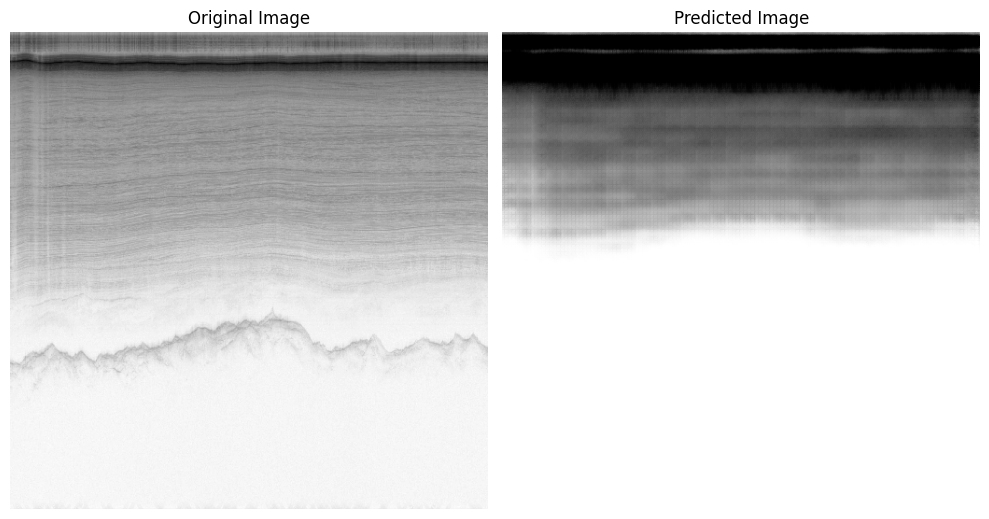

In [32]:
net = IceLayerTracer()
checkpoint_path = "/kaggle/working/checkpoint_epoch_9.pt"

def load_model(chkpoint_path, model):
    chkpoint = torch.load(chkpoint_path, weights_only=True)
    net.load_state_dict(chkpoint["model_state_dict"])
    print("Checkpoint Val Loss:", chkpoint["val_loss"].item())
    
def prepare_inputs(image_path):
    img = cv2.imread(image_path)
    transforms = create_test_augmentation()
    return transforms(image=img)["image"]
    
def predict(image_tensor, model):
    with torch.no_grad():
        model.eval()
        out = model(image_tensor)
        plot_og_and_new(image_tensor, out, ("Original Image", "Predicted Image"))


load_model(checkpoint_path, net)
img = prepare_inputs(random.choice(img_list))
predict(img, net)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from transformers import ViTModel, ViTConfig
from segmentation_models_pytorch import Unet, encoders

class IceLayerAnalysisModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Encoder Backbone
        self.encoder = self._build_encoder_backbone()
        
        # Feature Pyramid Network
        self.fpn = self._build_feature_pyramid()
        
        # Layer Tracking Branch
        self.layer_tracking = self._build_layer_tracking_branch()
        
        # Segmentation Branch
        self.segmentation = self._build_segmentation_branch()
        
        # Feature Detection Branch
        self.feature_detection = self._build_feature_detection_branch()
        
        # Initialize weights
        self.initialize_weights()
    
    def _build_encoder_backbone(self):
        # Use ResNet50 as the backbone encoder
        encoder = encoders.get_encoder(
            name="resnet50",
            in_channels=1,
            depth=5,
            weights=ResNet50_Weights.IMAGENET1K_V2
        )
        return encoder
    
    def _build_feature_pyramid(self):
        # Construct Feature Pyramid Network
        return nn.ModuleDict({
            "p1": nn.Sequential(
                nn.Conv2d(encoder.out_channels[0], 256, 1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            ),
            "p2": nn.Sequential(
                nn.Conv2d(encoder.out_channels[1], 256, 1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            ),
            "p3": nn.Sequential(
                nn.Conv2d(encoder.out_channels[2], 256, 1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            ),
            "p4": nn.Sequential(
                nn.Conv2d(encoder.out_channels[3], 256, 1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            )
        })
    
    def _build_layer_tracking_branch(self):
        # Use Transformer-based sequence modeling for layer tracking
        transformer_config = ViTConfig(
            num_layers=6,
            num_heads=8,
            hidden_size=256
        )
        return ViTModel(transformer_config)
    
    def _build_segmentation_branch(self):
        # Use Unet with ASPP module for segmentation
        return Unet(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=1,
            classes=self.config.num_layer_classes
        )
    
    def _build_feature_detection_branch(self):
        # Use attention-based feature detection
        return nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, self.config.num_feature_classes)
        )
    
    def initialize_weights(self):
        # Initialize weights for custom layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Encoder backbone
        encoder_features = self.encoder(x)
        
        # Feature Pyramid Network
        p1 = self.fpn["p1"](encoder_features[0])
        p2 = self.fpn["p2"](encoder_features[1])
        p3 = self.fpn["p3"](encoder_features[2])
        p4 = self.fpn["p4"](encoder_features[3])
        
        # Layer Tracking Branch
        layer_features = torch.cat([p1, p2, p3, p4], dim=1)
        layer_coords = self.layer_tracking(layer_features)[0]
        
        # Segmentation Branch
        segmentation_masks = self.segmentation(x)
        
        # Feature Detection Branch
        feature_maps = torch.cat([p1, p2, p3, p4], dim=1)
        feature_scores = self.feature_detection(feature_maps)
        
        return {
            "layers": layer_coords,
            "segmentation": segmentation_masks,
            "features": feature_scores
        }

In [ ]:
class IceLayerTrainer:
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.device = config.DEVICE
        self.scaler = GradScaler()  # For mixed precision training
        
        # Initialize optimizers
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )
        
        # Learning rate scheduler
        self.scheduler = CosineAnnealingWarmRestarts(
            self.optimizer,
            T_0=config.T_0,
            T_mult=config.T_MULT,
            eta_min=config.MIN_LR
        )

        
    def train_epoch(self, dataloader, epoch):
        self.model.train()
        total_loss = 0
        pbar = tqdm(enumerate(BackgroundGenerator(dataloader)), total=len(dataloader))
        for batch_idx, data in enumerate(dataloader):
            data = data.to(self.device)
            # targets = {k: v.to(self.device) for k, v in targets.items()}
            
            # Mixed precision training
            with autocast():
                # Forward pass
                outputs = self.model(data)
                
                # Calculate losses
                layer_loss = self.compute_layer_loss(
                    outputs['layers'], 
                    targets['layers']
                )
                seg_loss = self.compute_seg_loss(
                    outputs['segmentation'], 
                    targets['segmentation']
                )
                feature_loss = self.compute_feature_loss(
                    outputs['features'], 
                    targets['features']
                )
                
                # Weighted sum of losses
                loss = (
                    self.layer_weight * layer_loss +
                    self.seg_weight * seg_loss +
                    self.feature_weight * feature_loss
                )
            
            # Backward pass with gradient scaling
            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            total_loss += loss.item()
            
            # Progressive layer unfreezing
            if epoch > self.config.unfreeze_epoch:
                self._unfreeze_layers()
                
        # Update learning rate
        self.scheduler.step()
        
        return total_loss / len(dataloader)
    
    def train(self, train_loader, val_loader, num_epochs):
        """Complete training loop with curriculum learning"""
        best_val_loss = float('inf')
        
        for epoch in range(num_epochs):
            # Update curriculum difficulty
            if epoch in self.config.curriculum_milestones:
                self._increase_difficulty()
            
            # Train epoch
            train_loss = self.train_epoch(train_loader, epoch)
            
            # Validate
            val_loss = self.validate(val_loader)
            
            # Save checkpoint if best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_checkpoint(epoch, val_loss)
                
    def _increase_difficulty(self):
        """Implement curriculum learning strategy"""
        # Start with simple cases (clear layers, strong contrast)
        # Gradually introduce more complex cases
        self.train_dataset.increase_difficulty()
        
    def _unfreeze_layers(self):
        """Progressive unfreezing of layers"""
        for name, param in self.model.named_parameters():
            param.requires_grad = True
            
    def save_checkpoint(self, epoch, val_loss):
        """Save model checkpoint"""
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_loss': val_loss,
        }, f'checkpoint_epoch_{epoch}.pt')